In [1]:
# Data processing
import iris
import numpy as np
import xarray as xr
import warnings
from pathlib import Path
from datetime import datetime
from shapely.geometry import Point, Polygon
warnings.filterwarnings('ignore', module='iris')
warnings.filterwarnings('ignore', module='xarray')
# Visualization of vertical profiles
import string
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
plt.rcParams['mathtext.default'] = 'regular'
# Visualization of flight tracks and regions
import matplotlib.patches as mpatches
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
crs_main = ccrs.PlateCarree(central_longitude=180)
crs_aux = ccrs.PlateCarree()

### Global definitions and constants

In [2]:
SOURCES = ['atom', 'xojnl', 'xojnh', 'xojni', 'xojnc']
REGIONS = [
    (1, "n_pacific"),
    (2, "c_pacific"),
    (3, "s_pacific"),
    (4, "s_e_atlantic"),
    (5, "c_atlantic"),
    (6, "n_atlantic"),
    (7, "greenland"),
    (8, "w_canada"),
    ]
SEASONS = ["1702", "1608"]
SPECIES = {'ch4': {'latex':'$CH_4$', 'ppn':'ppbvC', 'min':1750, 'max':2050}, # 1700 2050
           'c2h6': {'latex':'$C_2H_6$', 'ppn':'pptvC', 'min':0, 'max':8000}, 
           'c3h8': {'latex':'$C_3H_8$', 'ppn':'pptvC', 'min':0, 'max':1000}, # of scale in West Canada
           'o3': {'latex':'$O_3$', 'ppn':'ppbv', 'min':0, 'max':100}, # 600
           'oh': {'latex':'OH', 'ppn':'pptv', 'min':0, 'max':3.5},
           'no': {'latex':'NO', 'ppn':'ppbv', 'min':0, 'max':0.1}, # 0.5
           'meono2': {'latex':'$MeONO_2$', 'ppn':'pptv', 'min':0, 'max':70},
           'etono2': {'latex':'$EtONO_2$', 'ppn':'pptv', 'min':0, 'max':10},
           'nprono2': {'latex':'$nPrONO_2$', 'ppn':'pptv', 'min':0, 'max':5},
           'iprono2': {'latex':'$iPrONO_2$', 'ppn':'pptv', 'min':0, 'max':25}}

### Prepare geospatical coordinates data
#### Read data

In [28]:
path_to_atom = Path.home() / 'UEA'/ 'PhD' / 'obs' / 'ATom' / 'nc' / 'data'
path_to_ukca = Path.home() / 'UEA'/ 'PhD' / 'models' / 'ukca' / 'raw'

# Read ATom data
atom_mms = {}
atom_was = {}
sample_lons, sample_lats = {}, {}  # for easy access of lon, lat
for season in SEASONS: #['1607', '1608', '1701', '1702']:  # TODO: replace this with SEASONS, because we don't need other data?
    atom_mms[season] = xr.open_mfdataset(sorted(path_to_atom.glob(f'MER-WAS_DC8_20{season}*.nc')), group='MMS', decode_cf=True)
    atom_was[season] = xr.open_mfdataset(sorted(path_to_atom.glob(f'MER-WAS_DC8_20{season}*.nc')), group='WAS', decode_cf=True)
    sample_lons[season] = atom_mms[season].G_LONG.values
    sample_lats[season] = atom_mms[season].G_LAT.values

# # Read UKCA horizontal coordinates
# ukca_lats = iris.load_cube(str(path_to_ukca / 'um_orography_xnvtj.nc'), 'OROGRAPHY (/STRAT LOWER BC)').coord('latitude') # not used
# ukca_lons = iris.load_cube(str(path_to_ukca / 'um_orography_xnvtj.nc'), 'OROGRAPHY (/STRAT LOWER BC)').coord('longitude')

In [29]:
the_species = 'c2h6'

In [30]:
species_deps = {
    'c2h6': ['Ethene_WAS', 'Ethyne_WAS', 'Ethane_WAS'],
}

In [31]:
# Propane_WAS + Propene_WAS
for season in SEASONS:
    _lon_lat = np.logical_or(*[np.isnan(atom_was[season][i].values) for i in atom_was[season][species_deps[the_species]]])
    sample_lons[season][_lon_lat] = np.nan
    sample_lats[season][_lon_lat] = np.nan

In [32]:
try:
    sample_lons['1608'][541], sample_lats['1608'][541] = None, None  # seems to be out of place
except KeyError:
    # No August 2016 in the dictionary, skipping this step
    pass

#### Define geographical regions of interest

In [33]:
# Construct pairs of coordinate points

flt_points = {}
for season in SEASONS:
    flt_points[season] = [Point(i, j) for i,j in zip(sample_lons[season], sample_lats[season])]

In [34]:
# Geographical regions
# https://media1.giphy.com/media/8HoHlbs5rhsLC/giphy.gif
# region_names = ['N Pacific', 'Central Pacific', 'S Pacific', 'SE Atlantic', 'Central Atlantic', 'N Atlantic', 'Greenland', 'W Canada']
r1_llon_ukca, r1_ulon_ukca = 195.9375, 214.6875
r1_llon, r1_ulon = r1_llon_ukca-360, r1_ulon_ukca-360
r1_llat, r1_ulat = 21.875, 53.125
r1 = Polygon([(r1_llon, r1_llat), (r1_llon, r1_ulat), (r1_ulon, r1_ulat), (r1_ulon, r1_llat)])
r2_llon_ukca, r2_ulon_ukca = 169.6875, 201.5625
r2_1_llon, r2_1_ulon = r2_llon_ukca, 180
r2_2_llon, r2_2_ulon = -180, r2_ulon_ukca-360
r2_llat, r2_ulat = -40.625, 20.625
r2_1 = Polygon([(r2_1_llon, r2_llat), (r2_1_llon, r2_ulat), (r2_1_ulon, r2_ulat), (r2_1_ulon, r2_llat)])
r2_2 = Polygon([(r2_2_llon, r2_llat), (r2_2_llon, r2_ulat), (r2_2_ulon, r2_ulat), (r2_2_ulon, r2_llat)])
r3_llon_ukca, r3_ulon_ukca = 180.9375, 285.9375
r3_llon, r3_ulon = r3_llon_ukca-360, r3_ulon_ukca-360
r3_llat, r3_ulat = -70.625, -50.625
r3 = Polygon([(r3_llon, r3_llat), (r3_llon, r3_ulat), (r3_ulon, r3_ulat), (r3_ulon, r3_llat)])
r4_llon_ukca, r4_ulon_ukca = 312.1875, 334.6875
r4_llon, r4_ulon = r4_llon_ukca-360, r4_ulon_ukca-360
r4_llat, r4_ulat = -45.625, -25.625
r4 = Polygon([(r4_llon, r4_llat), (r4_llon, r4_ulat), (r4_ulon, r4_ulat), (r4_ulon, r4_llat)])
r5_llon_ukca, r5_ulon_ukca = 323.4375, 344.0625
r5_llon, r5_ulon = r5_llon_ukca-360, r5_ulon_ukca-360
r5_llat, r5_ulat = -6.875, 36.875
r5 = Polygon([(r5_llon, r5_llat), (r5_llon, r5_ulat), (r5_ulon, r5_ulat), (r5_ulon, r5_llat)])
r6_llon_ukca, r6_ulon_ukca = 321.5625, 338.4375
r6_llon, r6_ulon = r6_llon_ukca-360, r6_ulon_ukca-360
r6_llat, r6_ulat = 38.125, 63.125
r6 = Polygon([(r6_llon, r6_llat), (r6_llon, r6_ulat), (r6_ulon, r6_ulat), (r6_ulon, r6_llat)])
r7_llon_ukca, r7_ulon_ukca = 269.0625, 321.5625
r7_llon, r7_ulon = r7_llon_ukca-360, r7_ulon_ukca-360
r7_llat, r7_ulat = 59.375, 81.875
r7 = Polygon([(r7_llon, r7_llat), (r7_llon, r7_ulat), (r7_ulon, r7_ulat), (r7_ulon, r7_llat)])
# r8_llon_ukca, r8_ulon_ukca = 237.1875, 269.0625
# r8_llon, r8_ulon = r8_llon_ukca-360, r8_ulon_ukca-360
# r8_llat, r8_ulat = 31.875, 50.625
# r8 = Polygon([(r8_llon, r8_llat), (r8_llon, r8_ulat), (r8_ulon, r8_ulat), (r8_ulon, r8_llat)])
r9_llon_ukca, r9_ulon_ukca = 201.5625, 233.4375 # between 234 and 237.1875 there is a spike in alkanes!
r9_llon, r9_ulon = r9_llon_ukca-360, r9_ulon_ukca-360
r9_llat, r9_ulat = 61.875, 81.875
r9 = Polygon([(r9_llon, r9_llat), (r9_llon, r9_ulat), (r9_ulon, r9_ulat), (r9_ulon, r9_llat)])

In [35]:
all_regions = {
    'N Pacific': {
        'polygon': r1,
        'plt_bounds': [r1_llon_ukca, r1_ulon_ukca, r1_llat, r1_ulat]
    },
    'Central Pacific': {
        'polygon': (r2_1, r2_2),
        'plt_bounds': [r2_llon_ukca, r2_ulon_ukca, r2_llat, r2_ulat]
    },
    'S Pacific': {
        'polygon': r3,
        'plt_bounds': [r3_llon_ukca, r3_ulon_ukca, r3_llat, r3_ulat]
    },
    'SE Atlantic': {
        'polygon': r4,
        'plt_bounds': [r4_llon_ukca, r4_ulon_ukca, r4_llat, r4_ulat]
    },
    'Central Atlantic': {
        'polygon': r5,
        'plt_bounds': [r5_llon_ukca, r5_ulon_ukca, r5_llat, r5_ulat]
    },
    'N Atlantic': {
        'polygon': r6,
        'plt_bounds': [r6_llon_ukca, r6_ulon_ukca, r6_llat, r6_ulat]
    },
    'Greenland': {
        'polygon': r7,
        'plt_bounds': [r7_llon_ukca, r7_ulon_ukca, r7_llat, r7_ulat]
    },
    'W Canada': {
        'polygon': r9,
        'plt_bounds': [r9_llon_ukca, r9_ulon_ukca, r9_llat, r9_ulat]
    }
}

In [36]:
def find_points_within(list_of_points, poly_region):
    """Find points within `list_of_points` that are within a polygon."""
    if isinstance(poly_region, (list, tuple, set)):
        # if a region comprises multiple parts
        within_region = []
        for i, p_r in enumerate(poly_region):
            within_each_poly = []
            for j, p in enumerate(list_of_points):
                within_each_poly.append(p.within(p_r))
            within_region.append(within_each_poly)
        within_region = np.logical_or(*within_region)
    elif isinstance(poly_region, Polygon):
        within_region = []
        for p in list_of_points:
            within_region.append(p.within(poly_region))
    else:
        raise ValueError("`poly_region` should be a shapely Polygon or a list of Polygons.")
    return np.asarray(within_region)

In [42]:
# indices_by_region_and_season = {}
# for region_name, region_dict in all_regions.items():
#     indices_by_region_and_season[region_name] = {}
#     for season in SEASONS:
#         indices_by_region_and_season[region_name][season] = find_points_within(flt_points[season], region_dict['polygon'])

In [38]:
# Name ATom stops
atom_stops = {'Palmdale': (34.581111, -118.100556), # lat, lon
              'Anchorage': (61.216667, -149.9),
              'Kona': (19.65, -155.994167),
              'Nadi': (-17.8, 177.416667),
              'Pago Pago': (-14.279444, -170.700556),
#               'Tafuna': (-14.335833, -170.72),
              'Christchurch': (-43.53, 172.620278),
              'Punta Arenas': (-53.166667, -70.933333),
              'Ascension': (-7.933333, -14.366667),
              'Azores': (37.741111, -25.675556),
              'Kangerlussuaq': (67.008611, -50.689167),
              'Minneapolis': (44.983333, -93.266667),
              'Thule': (77.466667, -69.230556)}
atom_stops_plt_kwargs = dict(transform=ccrs.PlateCarree(), color='w', marker='o', markeredgecolor='k')
atom_stops_txt_kwargs = dict(transform=ccrs.PlateCarree(), color='k', fontsize=14)

### Prepare vertical profiles data

In [39]:
def make_plots_with_map(figsize=(20, 15)):
    """
    Make a super plot.
    
    Parameters
    ----------
    figsize: tuple
        Figure size in inches.
    
    Returns
    -------
    fig: matplotlib.figure.Figure
        Parent figure.
    ax_dict: dict
        Dictionary of "vert_prof" axes for vertical profiles;
        and the "map" entry for a cartopy axes in the middle.
    """
    ncol = 10
    nrow = 4

    ax_dict = {}
    ax_dict["vert_prof"] = {}

    fig = plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(nrow, ncol, figure=fig, wspace=0.4, hspace=0.3)

    ax_dict["vert_prof"]["w_canada"] = plt.subplot(gs[0, 1:3]), plt.subplot(gs[0, 3:5])
    ax_dict["vert_prof"]["greenland"] = plt.subplot(gs[0, 5:7]), plt.subplot(gs[0, 7:9])

    ax_dict["vert_prof"]["n_pacific"] = plt.subplot(gs[1, :2]), plt.subplot(gs[1, 2:4])
    ax_dict["vert_prof"]["n_atlantic"] = plt.subplot(gs[1, 6:8]), plt.subplot(gs[1, 8:])
    ax_dict["vert_prof"]["c_pacific"] = plt.subplot(gs[2, :2]), plt.subplot(gs[2, 2:4])
    ax_dict["vert_prof"]["c_atlantic"] = plt.subplot(gs[2, 6:8]), plt.subplot(gs[2, 8:])
    ax_dict["vert_prof"]["s_pacific"] = plt.subplot(gs[3, 1:3]), plt.subplot(gs[3, 3:5])
    ax_dict["vert_prof"]["s_e_atlantic"] = (
        plt.subplot(gs[3, 5:7]),
        plt.subplot(gs[3, 7:9]),
    )

    ax_dict["map"] = plt.subplot(gs[1:3, 4:6], projection=crs_main)
    ax_dict["map"].coastlines()
    ax_dict["map"].set_extent([-200, -5, -90, 90], crs=crs_aux) # -200, 17, -90, 90
    ax_dict["map"].set_xticks([-180, -150, -120, -90, -60, -30], crs=crs_aux)
    ax_dict["map"].set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=crs_aux)
    ax_dict["map"].xaxis.set_major_formatter(lon_formatter)
    ax_dict["map"].yaxis.set_major_formatter(lat_formatter)

    return fig, ax_dict

#### Read vertical profiles data

In [15]:
path_to_prcd = Path.home() / 'UEA' / 'PhD' / 'models' / 'ukca' / 'processed' / 'vertical_profiles'

In [16]:
vrbls = {}
for src in SOURCES:
    vrbls[src] = {}
    for ir, reg in REGIONS:
        vrbls[src][reg] = {}
        for season in SEASONS:
            vrbls[src][reg][season] = {}
            for sp in SPECIES.keys():
                vrbls[src][reg][season][sp] = {}
                for vr in ['mean', 'std_dev']:
                    vrbls[src][reg][season][sp][vr] = iris.load_cube(str(path_to_prcd / f'vp_{season}_{src}_r{ir}_{sp}_{vr}.nc'))

In [17]:
# place = 'w_canada'

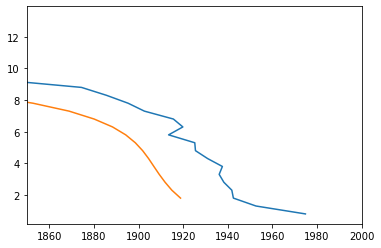

In [18]:
# plt.plot(vrbls['atom'][place]['1702']['ch4']['mean'].data, vrbls['xojnl']['w_canada']['1702']['ch4']['mean'].coord('altitude').points * 1e-3);
# plt.plot(vrbls['xojnl'][place]['1702']['ch4']['mean'].data, vrbls['xojnl']['w_canada']['1702']['ch4']['mean'].coord('altitude').points * 1e-3);
# plt.xlim(1850,2000);

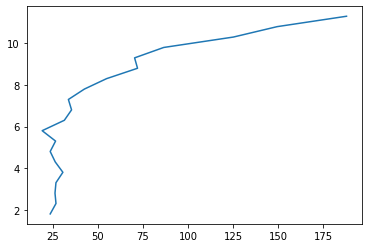

In [19]:
# plt.plot(vrbls['atom'][place]['1702']['ch4']['mean'].data - vrbls['xojnl'][place]['1702']['ch4']['mean'].data.squeeze(), vrbls['xojnl'][place]['1702']['ch4']['mean'].coord('altitude').points * 1e-3);

#### Plot vertical profiles for one selected species

In [20]:
path_to_figs = Path.home() / 'UEA' / 'PhD' / 'results' / 'xojn'

In [21]:
KWARGS = {'atom' : dict(color='k', fmt='-', linewidth=2, markersize=5, elinewidth=2, capsize=3, label='ATom'),
          'xojnl': dict(color='C2', fmt='-', linewidth=2, markersize=5, elinewidth=2, capsize=3, label='FULL'),
          'xojnh': dict(color='C6', fmt='-', linewidth=2, markersize=5, elinewidth=2, capsize=3, label='CHEM'),
          'xojni': dict(color='C0', fmt='-', linewidth=2, markersize=5, elinewidth=2, capsize=3, label='MARI'),
          'xojnc': dict(color='C3', fmt='-', linewidth=2, markersize=5, elinewidth=2, capsize=3, label='FIRE')}#,
#           'xojng': dict(color='C7', fmt='-o', linewidth=2, markersize=5, elinewidth=2, capsize=3, label='BASE')}

In [22]:
# grey and black for atom

In [40]:
season_plt_kw = {
    '1608': {
            'color': 'grey',
            'marker': 'o'
    },
    '1702': {
            'color': '#222222',
            'marker': 'o'
    },
}
kwargs_patch = dict(facecolor='r', alpha=0.2, edgecolor='k', transform=ccrs.PlateCarree())

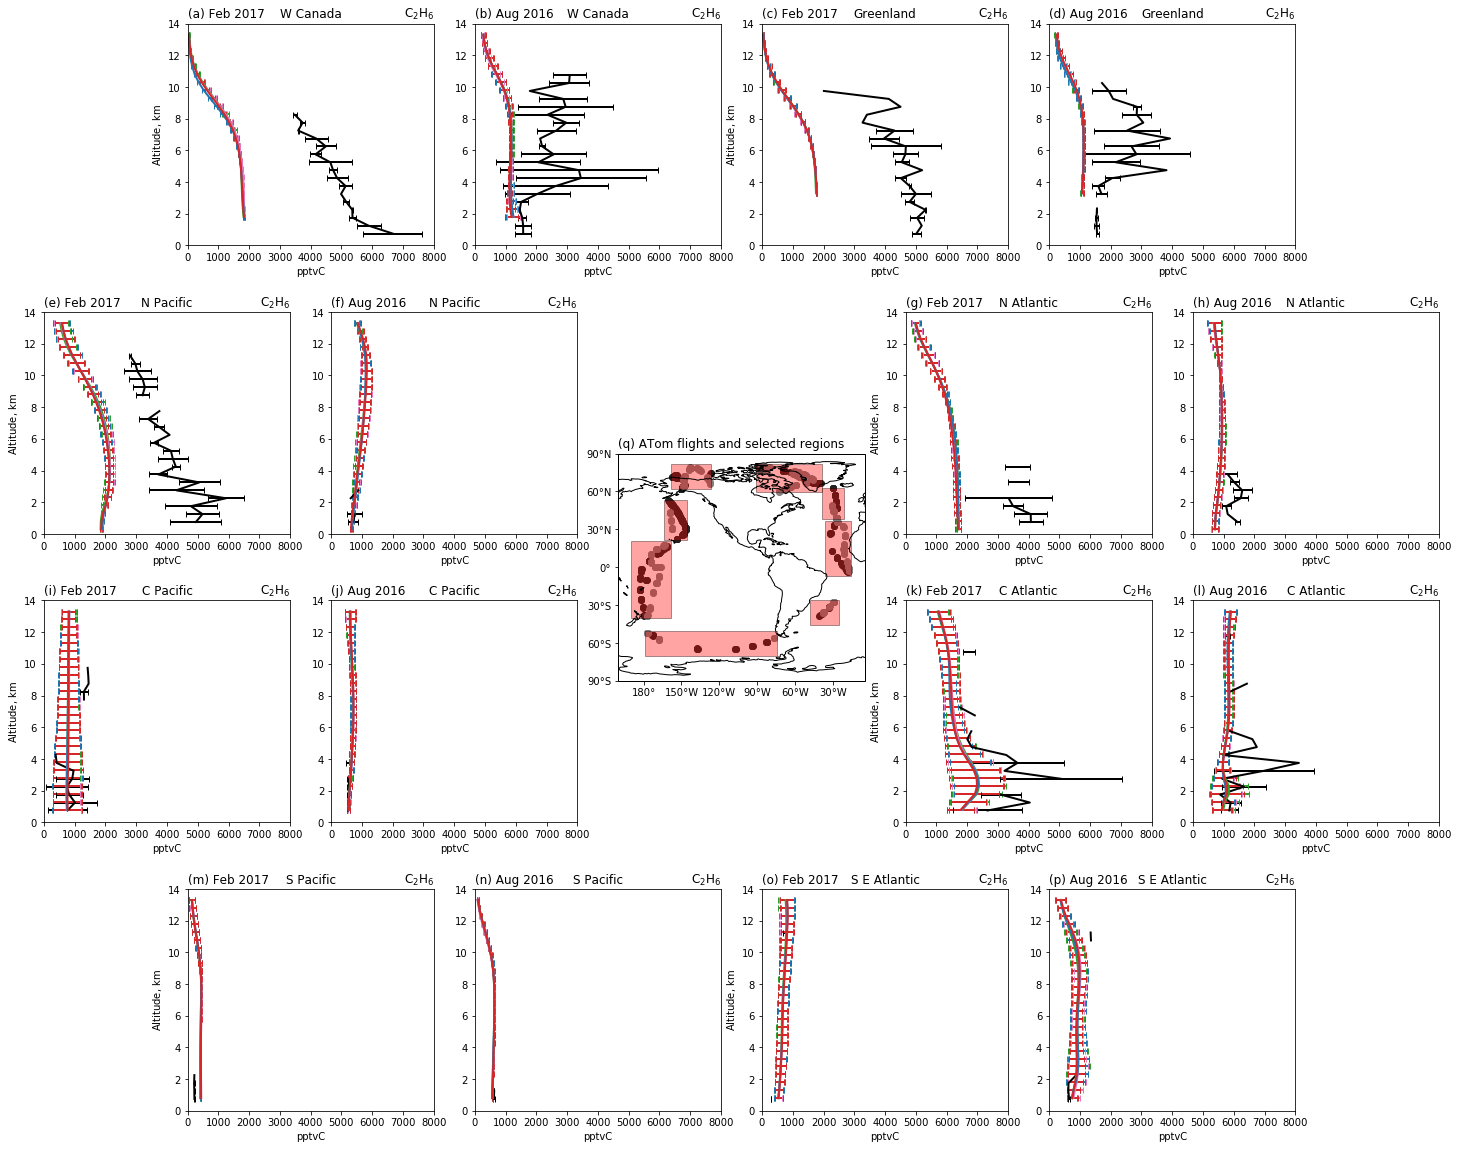

In [44]:
fig, ax_dict = make_plots_with_map(figsize=(25, 20))

ilabels = iter(string.ascii_lowercase)
for reg, ax_pair in ax_dict["vert_prof"].items():
    for i, (season, ax) in enumerate(zip(SEASONS, ax_pair)):
        for src in SOURCES:
            cubes = vrbls[src][reg][season][the_species]
            y = cubes['mean'].coord('altitude').points * 1e-3
            x = cubes['mean'].data
            xerr = cubes['std_dev'].data.squeeze()
            ax.errorbar(x, y, xerr=xerr, **KWARGS[src])
        
        season_name = datetime.strptime(season, '%y%m').strftime('%b %Y')
        ax.set_title(f"({next(ilabels)}) {season_name}", loc="left")
        ax.set_title(SPECIES[the_species]['latex'], loc="right")
        ax.set_title(reg.replace("_", " ").title(), loc="center")
        
        ax.set_xlim([SPECIES[the_species]['min'], SPECIES[the_species]['max']])
        ax.set_ylim([0, 14])
        if i == 0:
            # Add y-label only to the left plot
            ax.set_ylabel('Altitude, $km$')
        ax.set_xlabel(SPECIES[the_species]['ppn'])

ax_dict["map"].set_title(f"({next(ilabels)}) ATom flights and selected regions", loc="left")
for region_name, region_dict in all_regions.items():
    for season in SEASONS:
        season_name = datetime.strptime(season, '%y%m').strftime('%b %Y')
        inds = find_points_within(flt_points[season], region_dict['polygon'])
        _lons, _lats = sample_lons[season][inds], sample_lats[season][inds]
        ax_dict["map"].scatter(_lons, _lats, transform=ccrs.PlateCarree(), **season_plt_kw[season], label=season_name)

        bnds = region_dict['plt_bounds']
        ax_dict["map"].add_patch(mpatches.Rectangle(xy=[bnds[0], bnds[2]], width=bnds[1]-bnds[0], height=bnds[3]-bnds[2], **kwargs_patch))

# fig.savefig(path_to_figs / f'vps_{the_species}.png', bbox_inches='tight')